# Malware Classification with CNN

This notebook aims to build a **Convolutional Neural Network** model to perform a **Multiclass classification** of Malwares from the **Malimg Dataset**. 

# Data : 
A Malware can belong to one of the following class : 
 * Adialer.C
 * Agent.FYI
 * Allaple.A
 * Allaple.L
 * Alueron.gen!J
 * Autorun.K
 * C2LOP.P
 * C2LOP.gen!g
 * Dialplatform.B
 * Dontovo.A
 * Fakerean
 * Instantaccess
 * Lolyda.AA1
 * Lolyda.AA2
 * Lolyda.AA3
 * Lolyda.AT
 * Malex.gen!J
 * Obfuscator.AD
 * Rbot!gen
 * Skintrim.N
 * Swizzor.gen!E
 * Swizzor.gen!I
 * VB.AT
 * Wintrim.BX
 * Yuner.A

# Preprocessing - Converting to images

Raw malwares will be stored in the following folder:

In [ ]:
root = "/content"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data='/content/drive/MyDrive/AI for cyber_sec/malimg_paper_dataset_imgs'

The following function allows us to convert our hexadecimal **.bytes** files stored into our 'data' folder, into PNG images.

files :  ['.config', '0A32eTdBKayjCWhZqDOQ.bytes', '0ACDbR5M3ZhBJajygTuf.bytes', 'sample_data']
Processing 0A32eTdBKayjCWhZqDOQ.bytes
Processing 0ACDbR5M3ZhBJajygTuf.bytes


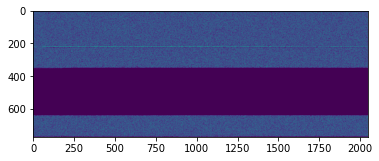

In [ ]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

## This function allows us to process our hexadecimal files into png images##
def convertAndSave(array,name):
    print('Processing '+name)
    if array.shape[1]!=16: #If not hexadecimal
        assert(False)
    b=int((array.shape[0]*16)**(0.5))
    b=2**(int(log(b)/log(2))+1)
    a=int(array.shape[0]*16/b)
    array=array[:a*b//16,:]
    array=np.reshape(array,(a,b))
    im = Image.fromarray(np.uint8(array))
    im.save(root+'//'+name+'.png', "PNG")
    return im

#Get the list of files
files=os.listdir("/content")
print('files : ',files)
#We will process files one by one.
for counter, name in enumerate(files):
        #We only process .bytes files from our folder.
        if '.bytes' != name[-6:]:
            continue
        f=open(root+'/'+name)
        array=[]
        for line in f:
            xx=line.split()
            if len(xx)!=17:
                continue
            array.append([int(i,16) if i!='??' else 0 for i in xx[1:] ])
        plt.imshow(convertAndSave(np.array(array),name))
        #del array
        f.close()

In [ ]:
from PIL import Image

img = Image.open('/content/0ACDbR5M3ZhBJajygTuf.png')
imgGray = img.convert('L')
imgGray.save('test_gray.png')
imgGray.show()

# Preprocessing - Generate the dataset

Here is our new folder :

In [ ]:
path_root = "/content/0A32eTdBKayjCWhZqDOQ.bytes"

To be able to use our images for training and testing, lets use **ImageDataGenerator.flow_from_directory()** which generates batches of normalized tensor image data from the respective data directories.
  * **target_size** : Will resize all images to the specified size. I personally chose (64*64) images.
  * **batch_size** : Is the size of the batch we will use. In our case, we only have 9339 images, hence setting a batch_size above this won't change anything.

In [ ]:
data="/content/drive/MyDrive/AI for cyber_sec/malimg_paper_dataset_imgs"

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=data, target_size=(64,64), batch_size=10000)

Found 9340 images belonging to 25 classes.


We can see that our 25 classes have been well recognized (thanks to our subfolders). Let's clarify this using the dictionary.

In [ ]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [ ]:
batches

**batches** generated with ImageDataGenerator() is an iterator. Hence, we use next() to go through all its elements and generate a batch of images and labels from the data set.

In [ ]:
imgs, labels = next(batches)

As you can see, our images are in RGB with shape 64x64 [width x length x depth].

In [ ]:
imgs.shape

(9340, 64, 64, 3)

**labels** has the shape (batch_size, number of classes).

In [ ]:
labels.shape

(9340, 25)

In [ ]:
labels

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

The following method allows us to plot a sample of images in our dataset.

In [ ]:
# plots images 
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

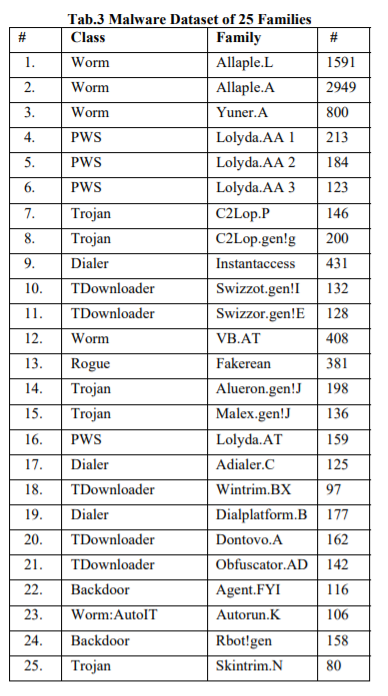

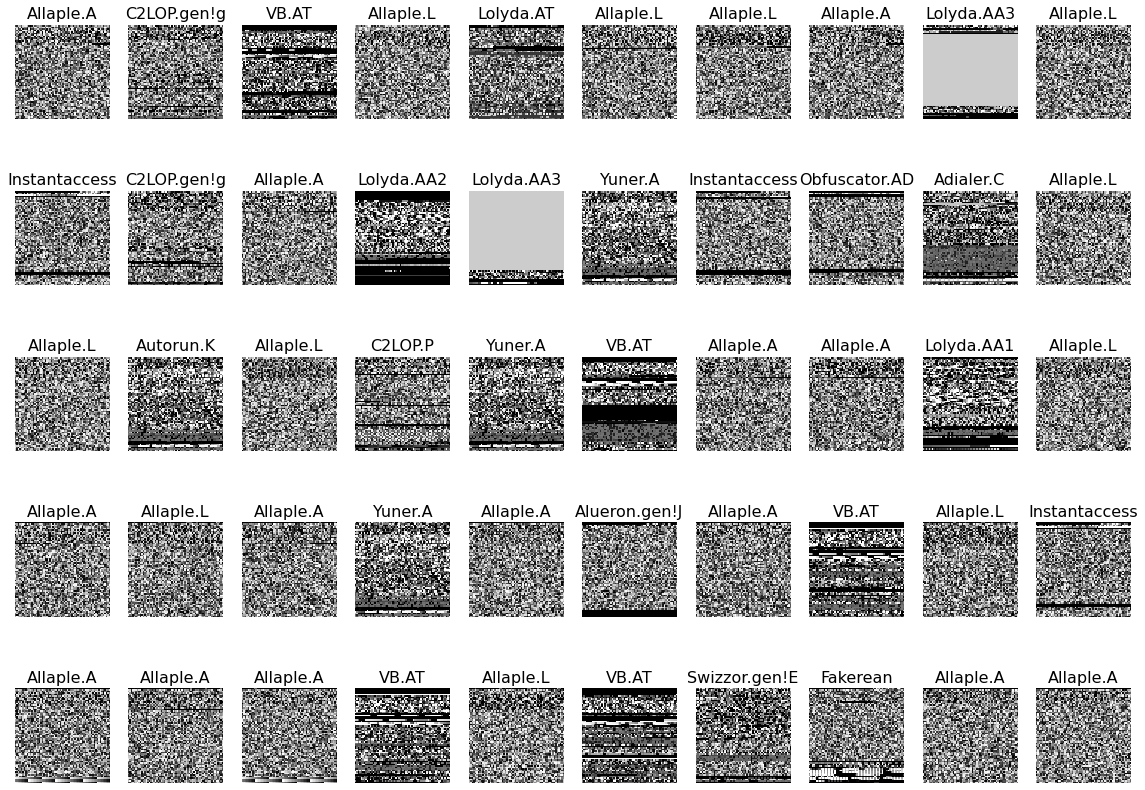

In [ ]:
plots(imgs, titles = labels)

We can already observe differences between classes.

# Analyse 

All our images are finally ready to be used. Lets check out the repartition of data between classes :

In [ ]:
classes = batches.class_indices.keys()

In [ ]:
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

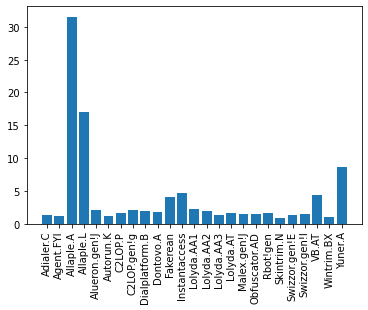

In [ ]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

We can see that our dataset is quite unbalanced : a lot of Malwares belong to class 2 : **Allaple.A** and class 3 : **Allaple.L** !
We will need to deal with that later. 

# Train and test

Lets split our model into train and test following a ratio 70% train - 30% test ratio.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [ ]:
X_train.shape

(6538, 64, 64, 3)

In [ ]:
X_test.shape

(2802, 64, 64, 3)

In [ ]:
y_train.shape

(6538, 25)

In [ ]:
y_test.shape

(2802, 25)

In [ ]:
import matplotlib.pyplot as plt


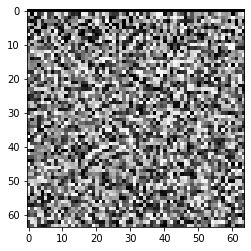

In [ ]:
plt.imshow(X_train[0])

In [ ]:
y_train1=y_train.reshape(-1,)
y_train1[:5]

array([0., 0., 1., 0., 0.], dtype=float32)

In [ ]:
#plt.imshow(y_train[0])
y_train1.shape

(163450,)

## Convolutional Neural Network Model

We will now build our **CNN** model using Keras. This model will have the following layers :

* **Convolutional Layer** : 30 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **Convolutional Layer** : 15 filters, (3 * 3) kernel size
* **Max Pooling Layer** : (2 * 2) pool size
* **DropOut Layer** : Dropping 25% of neurons.
* **Flatten Layer**
* **Dense/Fully Connected Layer** : 128 Neurons, Relu activation function
* **DropOut Layer** : Dropping 50% of neurons.
* **Dense/Fully Connected Layer** : 50 Neurons, Softmax activation function
* **Dense/Fully Connected Layer** : num_class Neurons, Softmax activation function

**Input shape** : 64 * 64 * 3

In [ ]:
import keras
from keras.models import Sequential, Input, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization

We want **25** classes as output.

In [ ]:
num_classes = 25

Building the model

In [ ]:
def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(30, kernel_size=(3,3),activation='relu',input_shape=(64,64,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return Malware_model

In [ ]:
Malware_model = malware_model()

In [ ]:
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 15)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 15)        0         
                                                                 
 flatten (Flatten)           (None, 2940)              0

Several methods are available to deal with unbalanced data. I our case, I chose to give higher weight to minority class and lower weight to majority class. 

**class_weights** uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. To use this method, y_train must not be one hot encoded.

In [ ]:
y_train.shape

(6538, 25)

**class_weight** function cannot deal with one hot encoded y. We need to convert it.

In [ ]:
y_train_new = np.argmax(y_train, axis=1)

In [ ]:
y_test_new = np.argmax(y_test, axis=1)

In [ ]:
y_train_new

array([ 2, 12, 24, ...,  3,  2, 24])

In [ ]:
malwares=['Adialer.C',
  'Agent.FYI',
 'Allaple.A',
 'Allaple.L',
 'Alueron.gen!J',
 'Autorun.K',
 'C2LOP.P',
 'C2LOP.gen!g',
 'Dialplatform.B',
 'Dontovo.A',
 'Fakerean',
 'Instantaccess',
 'Lolyda.AA1',
 'Lolyda.AA2',
 'Lolyda.AA3',
 'Lolyda.AT',
 'Malex.gen!J',
 'Obfuscator.AD',
 'Rbot!gen',
 'Skintrim.N',
 'Swizzor.gen!E',
 'Swizzor.gen!I',
 'VB.AT',
 'Wintrim.BX',
 'Yuner.A']

In [ ]:
def plot_sample(X,y,index):
  plt.figure(figsize=(15,2))
  plt.imshow(X_train[index])
  plt.xlabel(malwares[y_train_new[index]])

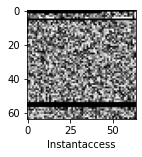

In [ ]:
plot_sample(X_train,y_train_new,1000)

In [ ]:
from sklearn.utils import class_weight
"""class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train_new),
                                                  y_train_new)"""
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train_new),
                                        y = y_train_new                                                   
                                    )
#class_weights = dict(zip(np.unique(y_train_new), class_weights)),
class_weights


array([3.00597701, 3.04093023, 0.12597303, 0.22760661, 2.01169231,
       3.48693333, 2.81204301, 1.92294118, 2.07555556, 2.19764706,
       1.00199234, 0.87173333, 1.54745562, 1.868     , 2.8426087 ,
       2.51461538, 2.87384615, 2.64161616, 2.53902913, 5.12784314,
       2.72416667, 3.00597701, 0.96147059, 4.28721311, 0.48882243])

In [ ]:
from tensorflow.keras import layers,models

cnn=models.Sequential([
                       #cnn
                       layers.Conv2D(30, kernel_size=(3,3),activation='relu',input_shape=(64,64,3)),
                       layers.MaxPooling2D(pool_size=(2, 2)),
                       layers.Dropout(0.25),
                       
                       
                       #dense
                       layers.Flatten(),
                       layers.Dense(128, activation='relu'),
                       layers.Dropout(0.5),
                       layers.Dense(50,activation='relu'),
                       layers.Dense(num_classes,activation='softmax')

])

In [ ]:
cnn.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
X_train

array([[[[0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         [0.00392157, 0.00392157, 0.00392157],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.8352941 , 0.8352941 , 0.8352941 ],
         [0.        , 0.        , 0.        ],
         [0.8980392 , 0.8980392 , 0.8980392 ],
         ...,
         [0.44313726, 0.44313726, 0.44313726],
         [0.8509804 , 0.8509804 , 0.8509804 ],
         [0.9411765 , 0.9411765 , 0.9411765 ]],

        [[0.23921569, 0.23921569, 0.23921569],
         [0.6       , 0.6       , 0.6       ],
         [0.01568628, 0.01568628, 0.01568628],
         ...,
         [0.6117647 , 0.6117647 , 0.6117647 ],
         [0.65882355, 0.65882355, 0.65882355],
         [0.76862746, 0.76862746, 0.76862746]],

        ...,

        [[0.827451  , 0.827451  , 0.827451  ],
         [0.8745098 , 0.8745098 , 0.8745098 ]

In [ ]:
import tensorflow as tf


tf.config.run_functions_eagerly(True)
cnn.fit(X_train,y_train)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


205/205 [==============================] - 31s 149ms/step - loss: 1.7165 - accuracy: 0.4901


In [ ]:
cnn.fit(X_train,y_train,epochs=10)

Epoch 1/10
  1/205 [..............................] - ETA: 28s - loss: 1.3800 - accuracy: 0.5625

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


205/205 [==============================] - 31s 150ms/step - loss: 0.8225 - accuracy: 0.7556
Epoch 2/10
205/205 [==============================] - 31s 149ms/step - loss: 0.5526 - accuracy: 0.8240
Epoch 3/10
205/205 [==============================] - 31s 149ms/step - loss: 0.4143 - accuracy: 0.8672
Epoch 4/10
205/205 [==============================] - 30s 148ms/step - loss: 0.3622 - accuracy: 0.8799
Epoch 5/10
205/205 [==============================] - 30s 148ms/step - loss: 0.3072 - accuracy: 0.8980
Epoch 6/10
205/205 [==============================] - 30s 147ms/step - loss: 0.2726 - accuracy: 0.9111
Epoch 7/10
205/205 [==============================] - 30s 148ms/step - loss: 0.2253 - accuracy: 0.9267
Epoch 8/10
205/205 [==============================] - 30s 148ms/step - loss: 0.2258 - accuracy: 0.9261
Epoch 9/10
205/205 [==============================] - 30s 147ms/step - loss: 0.2120 - accuracy: 0.9295
Epoch 10/10
205/205 [==============================] - 30s 147ms/step - loss: 0.2001

In [ ]:
#Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10,  class_weight=class_weights)
Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/10
205/205 [==============================] - 40s 197ms/step - loss: 1.7276 - accuracy: 0.4653 - val_loss: 0.9108 - val_accuracy: 0.6934
Epoch 2/10
205/205 [==============================] - 40s 193ms/step - loss: 0.8787 - accuracy: 0.7092 - val_loss: 0.4828 - val_accuracy: 0.8701
Epoch 3/10
205/205 [==============================] - 39s 193ms/step - loss: 0.5669 - accuracy: 0.8322 - val_loss: 0.3517 - val_accuracy: 0.9011
Epoch 4/10
205/205 [==============================] - 40s 196ms/step - loss: 0.3962 - accuracy: 0.8809 - val_loss: 0.2447 - val_accuracy: 0.9176
Epoch 5/10
205/205 [==============================] - 39s 192ms/step - loss: 0.3303 - accuracy: 0.8980 - val_loss: 0.2110 - val_accuracy: 0.9304
Epoch 6/10
205/205 [==============================] - 40s 196ms/step - loss: 0.2790 - accuracy: 0.9162 - val_loss: 0.1644 - val_accuracy: 0.9479
Epoch 7/10
205/205 [==============================] - 39s 191ms/step - loss: 0.2301 - accuracy: 0.9273 - val_loss: 0.1468 - val_ac

In [ ]:
scores = Malware_model.evaluate(X_test, y_test)

 2/88 [..............................] - ETA: 4s - loss: 0.0759 - accuracy: 0.9844

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


88/88 [==============================] - 5s 55ms/step - loss: 0.1288 - accuracy: 0.9622


In [ ]:
scores = cnn.evaluate(X_test, y_test)

 3/88 [>.............................] - ETA: 3s - loss: 0.1681 - accuracy: 0.9375

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


88/88 [==============================] - 4s 43ms/step - loss: 0.1392 - accuracy: 0.9536


In [ ]:
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.9536045789718628


# **Confusion Matrix**

In [ ]:
import numpy as np
import pandas as pd

In [ ]:

predictions = cnn.predict(X_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
y_pred = cnn.predict(X_test, verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
y_pred[:5]

array([[4.50255410e-21, 1.98056652e-20, 2.11838163e-14, 3.21961566e-18,
        1.48781356e-12, 7.12809817e-22, 2.10437168e-10, 2.46742121e-14,
        1.18307345e-14, 4.46321671e-16, 4.40074191e-26, 9.99997735e-01,
        8.43816086e-15, 1.58563764e-19, 8.18820272e-20, 5.26342546e-14,
        2.25873828e-06, 3.51401037e-14, 9.50727356e-16, 1.24936380e-16,
        4.10740879e-14, 1.00335408e-12, 3.75247446e-12, 6.60816936e-16,
        5.99436040e-22],
       [4.40015052e-10, 4.30366610e-11, 9.99775112e-01, 5.67287643e-05,
        2.95584757e-09, 3.04115899e-10, 3.30204489e-06, 1.47936913e-10,
        7.70342054e-11, 1.52943297e-10, 1.57394919e-09, 5.21789101e-09,
        9.90125049e-09, 3.23652355e-11, 5.23029398e-10, 2.30221513e-08,
        1.64758021e-04, 5.49998380e-10, 2.47561346e-12, 2.39156750e-10,
        4.33743069e-10, 3.49734297e-10, 1.46612653e-11, 1.96513938e-09,
        4.22090252e-10],
       [9.19305592e-07, 6.71189770e-09, 1.15188366e-08, 1.27435289e-08,
        2.0882

 **cross checking the first 5 predictions with y_test**

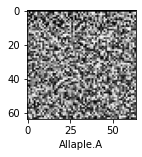

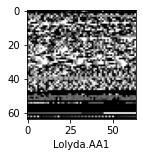

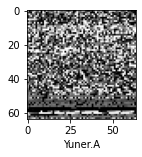

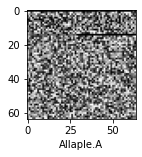

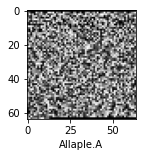

In [ ]:
for x in range (0,5):
  plot_sample(X_test,y_test,x)

     

In [ ]:
y_classes=[np.argmax(element) for element in y_pred]
y_classes[:5]

[11, 2, 24, 2, 3]

In [ ]:
y_test2 = np.argmax(y_test, axis=1)

In [ ]:
y_test2[:5]

array([11,  2, 24,  2,  3])

In [ ]:
from sklearn import metrics
c_matrix = metrics.confusion_matrix(y_test2, y_pred.argmax(axis=1))

In [ ]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

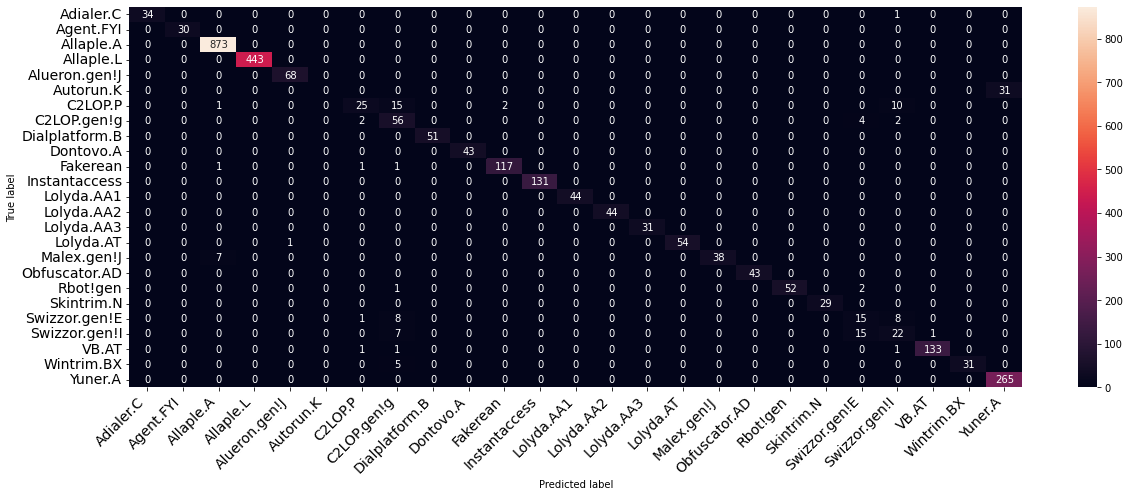

In [ ]:
class_names= batches.class_indices.keys()
confusion_matrix(c_matrix, class_names, figsize = (20,7), fontsize=14)